In [25]:
%load_ext autoreload
%autoreload 2
from load import *
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
import load
from liftpose.vision_3d import XY_coord, Z_coord

reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)

# decleare data parameters
par_train = {'data_dir'       : '/data/LiftPose3D/mouse_prism', # change the path 
       'out_dir'        : './out',
       'train_subjects' : ['G6AE1','G6AE2','G6AE3','G6AE5'],
       'test_subjects'  : ['G6AE6'],
       'actions'        : ['control']}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# Load data
train, train_keypts, _ = load.load_3D( par['data_dir'], subjects=par['train_subjects'], actions=par['actions'] )
test,  test_keypts, _ = load.load_3D( par['data_dir'], subjects=par['test_subjects'],  actions=par['actions'] )

train = {k:np.squeeze(v) for (k,v) in train.items()}
test = {k:np.squeeze(v) for (k,v) in test.items()}

train_2d, train_3d = XY_coord(train), Z_coord(train)
test_2d, test_3d  = XY_coord(test), Z_coord(test)
train_2d = {k:np.squeeze(v) for (k,v) in train_2d.items()}
test_2d = {k:np.squeeze(v) for (k,v) in test_2d.items()}
train_3d = {k:np.squeeze(v) for (k,v) in train_3d.items()}
test_3d = {k:np.squeeze(v) for (k,v) in test_3d.items()}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
from liftpose.main import train as lp3d_train
lp3d_train(train_2d=train_2d, test_2d=test_2d, train_3d=train_3d, test_3d=test_3d, 
           train_keypts=train_keypts, test_keypts=test_keypts, 
           roots=par['roots'], target_sets=par['targets'], in_dim=par['in_dim'], 
           out_dim=par["out_dim"], out_dir=par['out_dir'])

(462, 14)
(14,)
(462, 12)
[main.py:94]:INFO:Saving pre-processed 2D data at /home/user/Desktop/LiftPose3D/examples/mouse_prism_package/out/stat_2d.pth.tar.
[main.py:118]:INFO:Saving pre-processed 3D data at /home/user/Desktop/LiftPose3D/examples/mouse_prism_package/out/stat_3d.pth.tar.
[main.py:146]:INFO:Starting training model
[main.py:155]:DEBUG:
==================Options=================
[main.py:156]:DEBUG:{   'batch_size': 64,
    'data_dir': '/home/user/Desktop/LiftPose3D/examples/mouse_prism_package/out',
    'dropout': 0.5,
    'epochs': 10,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 100000,
    'lr_gamma': 0.96,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/home/user/Desktop/LiftPose3D/examples/mouse_prism_package/out',
    'out_dir': '/home/user/Desktop/LiftPose3D/examples/mouse_prism_package/out',
    'predict': False,
    'procrustes': False,
    'resume': False,


Epoch 0 | Loss Test 0 | Loss Train 2.2831|: 100%|██████████| 523/523 [00:06<00:00, 75.09it/s]
Epoch 1 | Loss Test 2.4459 | Loss Train 0.97878|: 100%|██████████| 523/523 [00:07<00:00, 74.59it/s]
Epoch 2 | Loss Test 2.1674 | Loss Train 0.87817|: 100%|██████████| 523/523 [00:05<00:00, 98.03it/s] 
Epoch 3 | Loss Test 1.7977 | Loss Train 0.84769|: 100%|██████████| 523/523 [00:06<00:00, 78.62it/s]
Epoch 4 | Loss Test 1.4093 | Loss Train 0.82595|: 100%|██████████| 523/523 [00:07<00:00, 73.67it/s]
Epoch 5 | Loss Test 2.717 | Loss Train 0.80635|: 100%|██████████| 523/523 [00:06<00:00, 80.78it/s] 
Epoch 6 | Loss Test 1.0989 | Loss Train 0.78088|: 100%|██████████| 523/523 [00:06<00:00, 82.24it/s]
Epoch 7 | Loss Test 1.1004 | Loss Train 0.76573|: 100%|██████████| 523/523 [00:05<00:00, 98.94it/s] 
Epoch 8 | Loss Test 1.1816 | Loss Train 0.74571|: 100%|██████████| 523/523 [00:06<00:00, 76.50it/s]
Epoch 9 | Loss Test 1.1211 | Loss Train 0.72984|: 100%|██████████| 523/523 [00:05<00:00, 97.10it/s] 


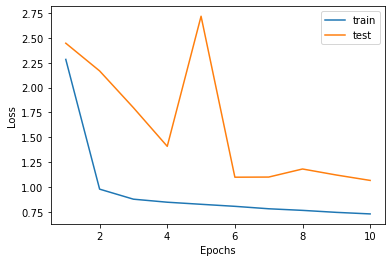

In [27]:
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

In [28]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:162]:INFO:starting testing in path: ./out
[lift.py:54]:INFO:total params: 4.23M
[lift.py:60]:INFO:loading ckpt from './out/ckpt_best.pth.tar'
[lift.py:68]:INFO:ckpt loaded (epoch: 9 | err: 2.159269332885742)
[lift.py:106]:INFO:Saving results: /home/user/Desktop/LiftPose3D/examples/mouse_prism_package/out/test_results.pth.tar


In [29]:
from liftpose.postprocess import load_test_results
test_3d, test_3d_pred = load_test_results(par['out_dir'])

In [30]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
%matplotlib widget
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=200, azim=60)

t = 900
plot_pose_3d(ax, test_3d[t], 
            test_3d_pred[t], 
            par["ndims"], 
            np.array(par_data["vis"]["bones"]), 
            par_data["vis"]["limb_id"], 
            par_data["vis"]["colors"])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

ValueError: cannot reshape array of size 7 into shape (3)